In [1]:
#CHDIR COMMAND ONLY FOR JUPYTER
import os
import sys
sys.path.append("/mnt/scratch/henrypurcell/N3AS/Emu_scripts/data_reduction")
import yt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import h5py
import amrex_plot_tools as amrex
import emu_yt_module as emu
import spin_flip_tools as sft
import glob
import concurrent
import matplotlib as mpl
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator,LogLocator)
from matplotlib import cm, colors
import matplotlib.axes as ax
from mpl_toolkits.mplot3d import Axes3D
#import latex
from itertools import product


# For ease of development, reload the relevant modules to make sure they are up to date.
import importlib
importlib.reload(sft)

################
# plot options #
################
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'
mpl.rcParams['font.size'] = 10
mpl.rcParams['font.family'] = 'serif'
COLOR = 'black'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
#mpl.rc('text', usetex=True)
mpl.rcParams['xtick.major.size'] = 7
mpl.rcParams['xtick.major.width'] = 2
mpl.rcParams['xtick.major.pad'] = 8
mpl.rcParams['xtick.minor.size'] = 4
mpl.rcParams['xtick.minor.width'] = 2
mpl.rcParams['ytick.major.size'] = 7
mpl.rcParams['ytick.major.width'] = 2
mpl.rcParams['ytick.minor.size'] = 4
mpl.rcParams['ytick.minor.width'] = 2
mpl.rcParams['axes.linewidth'] = 2
mpl.rcParams['axes.grid'] = True
#fig,ax = plt.subplots()

def sin(theta):
    return np.sin(theta)
def cos(theta):
    return np.cos(theta)
def exp(x):
    return np.exp(x)
pi=np.pi

In [2]:
class Interact:
    def __init__(self, data_base_directory, theta=0, phi=0, output_name = None, output_append = '_sfm_'):
        self.data_base_directory = data_base_directory
        self.theta = theta
        self.phi = phi
        if output_name == None:
            self.output_filename = data_base_directory[0:-3] + output_append
        else: 
            self.output_filename = output_name + output_append
    
    def is_h5(self):
        if self.data_base_directory[-3:]=='.h5':
            return True
        else: 
            return False
    
    #interact function
    def run(self, anglename):
      
        if self.is_h5() == True:      
        #runs interact for h5 files, outputs [filename]_spin_flip_matrices.h5 in same location
       
        #find number of time intervals
            File=h5py.File(self.data_base_directory,"r")
            nt=len(np.array(File["t(s)"]))
            File.close()

            for t in range(0,nt):
                sft.interact(self.data_base_directory, self.output_filename + anglename + '.h5', self.theta, self.phi, t)
        
        else: #runs interact, for plt files. outputs h5 'spin_flip_matrices' file inside of data_base_directory
            directory_list = sorted(glob.glob(self.data_base_directory+"plt*"))
           
            if os.path.exists(self.output_filename):
                os.remove(self.output_filename)

            for d in directory_list:
                print(d)
                with concurrent.futures.ProcessPoolExecutor(max_workers=1) as executor:
                    executor.submit(sft.interact, d, self.output_filename + anglename + '.h5', self.theta, self.phi)
    
    #interact_J, which just outputs the flux to save space
    def run_J(self):
      
        if self.is_h5() == True:      
        #runs interact for h5 files, outputs [filename]_spin_flip_matrices.h5 in same location
       
        #find number of time intervals
            File=h5py.File(self.data_base_directory,"r")
            nt=len(np.array(File["t(s)"]))
            File.close()

            for t in range(0,nt):
                sft.interact_J(self.data_base_directory, self.output_filename+'J.h5', t)
        
        else: #runs interact, for plt files. outputs h5 'spin_flip_matrices' file inside of data_base_directory
            directory_list = sorted(glob.glob(self.data_base_directory+"plt*"))
           
            if os.path.exists(self.output_filename):
                os.remove(self.output_filename)

            for d in directory_list:
                print(d)
                with concurrent.futures.ProcessPoolExecutor(max_workers=1) as executor:
                    executor.submit(sft.interact_J, d, self.output_filename)
        

In [4]:
#inputdatafile carries files of the form /i*j*k*/allData.h5. output_loc + output_name is the file where you want to store the output h5 files
class Multipoint_interact:
    def __init__(self, output_name, inputdatafile = '/mnt/scratch/shared/Henry_NSM_box', output_loc = '/mnt/scratch/henrypurcell/N3AS/data/'):
        self.inputdatafile = inputdatafile
        self.filelist = glob.glob(self.inputdatafile + "/i*j*k*/allData.h5")
        self.outputdatafile = output_loc + output_name
        
    def interact(self):
        os.mkdir(self.outputdatafile)
        
        for h5file in self.filelist:
            coords = h5file[-26:-11] #just the coordinate part
            Interact(h5file, output_name = self.outputdatafile + coords, output_append = '_sfm').run_J()
        
               

In [ ]:
Multipoint_interact('sfm', inputdatafile = '/mnt/scratch/shared/Henry_NSM_box').interact()

In [4]:
Multipoint_interact('sfm_test', inputdatafile = '/mnt/scratch/henrypurcell/N3AS/test_input/').interact()

In [6]:
"/i000j000k000/allData.h5"[-23:]

'i000j000k000/allData.h5'

In [5]:
os.mkdir('/mnt/scratch/henrypurcell/N3AS/data/lol')

In [13]:
Interact('/mnt/scratch/henrypurcell/N3AS/data/i106_j136_k099_highres.h5', theta=0).run(anglename='z')

In [4]:
def gellmann(j, k, d):
    r"""Returns a generalized Gell-Mann matrix of dimension d. According to the
    convention in *Bloch Vectors for Qubits* by Bertlmann and Krammer (2008),
    returns :math:`\Lambda^j` for :math:`1\leq j=k\leq d-1`,
    :math:`\Lambda^{kj}_s` for :math:`1\leq k<j\leq d`,
    :math:`\Lambda^{jk}_a` for :math:`1\leq j<k\leq d`, and
    :math:`I` for :math:`j=k=d`.

    :param j: First index for generalized Gell-Mann matrix
    :type j:  positive integer
    :param k: Second index for generalized Gell-Mann matrix
    :type k:  positive integer
    :param d: Dimension of the generalized Gell-Mann matrix
    :type d:  positive integer
    :returns: A genereralized Gell-Mann matrix.
    :rtype:   numpy.array

    """

    if j > k:
        gjkd = np.zeros((d, d), dtype=np.complex128)
        gjkd[j - 1][k - 1] = 1
        gjkd[k - 1][j - 1] = 1
    elif k > j:
        gjkd = np.zeros((d, d), dtype=np.complex128)
        gjkd[j - 1][k - 1] = -1.j
        gjkd[k - 1][j - 1] = 1.j
    elif j == k and j < d:
        gjkd = np.sqrt(2/(j*(j + 1)))*np.diag([1 + 0.j if n <= j
                                               else (-j + 0.j if n == (j + 1)
                                                     else 0 + 0.j)
                                               for n in range(1, d + 1)])
    else:
        gjkd = np.diag([1 + 0.j for n in range(1, d + 1)])

    return gjkd


def get_GM(d):
    r'''Return a basis of orthogonal Hermitian operators on a Hilbert space of
    dimension d, with the identity element in the last place.

    '''
    return np.array([gellmann(j, k, d) for j, k in product(range(1, d + 1), repeat=2)])

# finds Gell Mann projection vector of a matrix
def GM_projection(M):
    matrix_size = np.shape(M)[0]
    GM_components = get_GM(matrix_size)
    return np.array([np.trace(0.5*GM_components[n] @ M) for n in np.arange(0, matrix_size**2-1)])

#scalar magnitude of GM projection
def GM_magnitude(M):
    return np.linalg.norm(GM_projection(M))

#magnitude of array by just squaring and adding all components. this is equivalent to the above if you're looking at an off-diagonal subset of an array (eg HLR).
def sum_magnitude(M):
    size=M.shape[0]
    M_flattened = M.reshape(size**2)
    return np.linalg.norm(M_flattened)

#returns H dot P as Gell Mann projection vectors. Resonance occurs when this is 0 
def GM_dotprod(H, P):
    if np.shape(H)[0] != np.shape(P)[0]:
        raise TypeError('H and P have different dimensions')
        return
    else: 
        return np.dot(np.real(GM_projection(H)),np.real(GM_projection(P)))
    
#takes in value that depends on theta, phi and returns a theta_res by phi_res array of values 
def angularArray(func, theta_res, phi_res):   
    return np.array([[func(theta, phi) for phi in np.linspace(0, 2*pi, phi_res)]
                                      for theta in np.linspace(0, pi, theta_res)])

def rm_trace(M):
    return np.array(M) - np.trace(M)*np.identity(np.array(M).shape[0])/np.array(M).shape[0]

def visualizer(M, log=True, text=False, traceless = False, vmin=1E-15,vmax=1E-6):
    if traceless ==True:
        M=rm_trace(M)
    else:
        M=np.array(M)
    
    matrix_size = M.shape[0]
    grid_subdivisions = 1/matrix_size
    vertices_x = [n*grid_subdivisions for n in np.arange(0,matrix_size+1)]
    vertices_y = [n*grid_subdivisions for n in np.arange(matrix_size,-1,-1)]
    
    min_value=vmin
    max_value=vmax
    
    if log ==True: scale = norm=colors.LogNorm(vmin=min_value, vmax=max_value)
    else: scale = None
    
    
    f, ax = plt.subplots()
    ax.set_ylim(0,1)
    ax.set_xlim(0,1)
    
    image = ax.pcolormesh(vertices_x,vertices_y,np.abs(M),cmap='hot',norm=scale)
    plt.colorbar(image)
    
    if text=='mag':
        for n in np.arange(0,matrix_size):
            for m in np.arange(0,matrix_size):
                xcoord = (n+1/6)*grid_subdivisions
                ycoord = 1 - (m+1/2)*grid_subdivisions
                ax.text(xcoord, ycoord, str(round(np.log10(np.abs(M[m,n])),0)), color='cyan', size=10)
                
    elif text=='arg':
        for n in np.arange(0,matrix_size):
            for m in np.arange(0,matrix_size):
                xcoord = (n)*grid_subdivisions
                ycoord = 1 - (m+1/2)*grid_subdivisions
                ax.text(xcoord, ycoord, str(round(np.real(M[m,n]/np.abs(M[m,n])), ndigits=1))+'+'+str(round(np.imag(M[m,n])/np.abs(M[m,n]), ndigits=2))+'i', color='cyan', size=9)

In [5]:
#datafile = location name
class SpinFlip:
    def __init__(self, datafile):
        self.datafile = datafile
    
    #show keys
    def keys(self):
        readdata =  h5py.File(self.datafile, "r")
        return list(readdata.keys())
    
    #add GM components
    def add_GM(self):
        #adds GM components of flux
        readdata =  h5py.File(self.datafile, "r")
        if 'GM(eV^3)R' in list(readdata.keys()):
            print('Already computed')
            return
        else:
            GM_data = sft.GM_components(readdata) 
            readdata.close()
            appenddata =  h5py.File(self.datafile, "a")
            sft.append_to_hdf5(appenddata, "GM(eV^3)", GM_data)
            appenddata.close()
    
    #plotter
    def plotter(self, quantity, basis=0, Title = None, savefig = False):
        
        readdata = h5py.File(self.datafile, "r")
        t = np.array(readdata["t(s)"])
        
        f, ax = plt.subplots()
       
        if quantity == 'J': 
            J = sft.total(readdata,"J(eV^3)")
            plt.semilogy(t*1E9,np.average(sft.scalarfunc_time(J[:,basis,:,:,:]), axis=1))
            ax.set_ylabel(r"$eV^3$")
        
        elif quantity == 'J_v_space': 
            J = sft.total(readdata,"J(eV^3)")
            plt.plot(np.average(sft.scalarfunc_time(J[:,basis,:,:,:]), axis=1))
            ax.set_ylabel(r"$eV^3$")
        
        elif quantity == 'GM': 
            GM = sft.total(readdata,"GM(eV^3)")
            plt.semilogy(t*1E9,np.average(sft.scalarfunc_time(GM[:,basis,:,:,:]), axis=1))
            ax.set_ylabel(r"$eV^3$")
        
        elif quantity == 'H_LR_GM_mag':
            H_LR=sft.total(readdata,"H_LR(eV)")
            HLR_t=[GM_magnitude(np.average(H_LR[t,:,:,:], axis=2)) for t in np.arange(0,H_LR.shape[0])]
            ax.set_ylabel(r"$|H_{LR}| \ \ (eV)$")
            plt.semilogy(t*1E9,HLR_t)
        
        elif quantity == 'H_LR':
            H_LR=sft.total(readdata,"H_LR(eV)")
            ax.set_ylabel(r"$|H_{LR}| \ \ (eV)$")
            plt.semilogy(t*1E9,np.average(sft.scalarfunc_time(H_LR[:,:,:,:]), axis=1))
       
        elif quantity == 'H_LR_sum':
            H_LR=sft.total(readdata,"H_LR(eV)")
            ax.set_ylabel(r"$|H_{LR}| \ \ (eV)$")
            plt.semilogy(t*1E9,np.average(sft.scalarfunc_sum_time(H_LR[:,:,:,:]), axis=1))
        
        elif quantity == 'J_all':
            J = sft.total(readdata,"J(eV^3)")
            ax.set_ylabel(r"$eV^3$")
            plt.semilogy(t*1E9,np.average(sft.scalarfunc_time(J[:,1,:,:,:]), axis=1), label = 'x')
            plt.semilogy(t*1E9,np.average(sft.scalarfunc_time(J[:,2,:,:,:]), axis=1), label = 'y')
            plt.semilogy(t*1E9,np.average(sft.scalarfunc_time(J[:,3,:,:,:]), axis=1), label = 'z')
            ax.legend()
        
        elif quantity == 'H_LR_00':
            H_LR=sft.total(readdata,"H_LR(eV)")
            ax.set_ylabel(r"$|H_{LR}| \ \ (eV)$")
            plt.semilogy(t*1E9,np.average(H_LR[:,0,0,:], axis=1), label = 'electron component')
            plt.semilogy(t*1E9,np.average(H_LR[:,1,1,:], axis=1), label = 'muon component')
            plt.semilogy(t*1E9,np.average(H_LR[:,2,2,:], axis=1), label = 'tau component')
            ax.legend()
            ax.set_ylim(1E-25,1E-15)
        elif  quantity == 'kappa':
            kappa=sft.total(data,'S_R_kappa(eV)')
            ax.set_ylabel(r"$eV$")
            plt.plot(t*1E9,np.average(kappa[:,0,0,:], axis=1))
            

        
        
        
        if Title == None:
            ax.set_title('basis = '+str(basis)+', quantity = ' + quantity)
        else: 
            ax.set_title(Title)
        
        ax.set_xlabel("time (ns)")
        mpl.pyplot.tick_params(axis='both',which="both", direction="in",top=True,right=True)
        mpl.pyplot.minorticks_on()
  
        
        if savefig == True: 
            plt.tight_layout()
            plt.savefig('../'+quantity+'.png', dpi=300)
    
        else: pass
       
    def angular_plot(self, theta_precision = 200, phi_precision = 100):
        
        H_LR_angular = np.transpose((np.array([[((np.real(self.H_LR_at_basis(theta,phi)[0,0]))**2
                                               + (np.imag(self.H_LR_at_basis(theta,phi)[0,0]))**2)**(1/2)
                                            for theta in np.linspace(0,np.pi,200)] 
                                            for phi in np.linspace(0,2*np.pi,100)])))
        resonance_angular = np.transpose((np.array([[np.real(self.resonance_at_basis(theta,phi))  
                                            for theta in np.linspace(0,np.pi,200)] 
                                            for phi in np.linspace(0,2*np.pi,100)])))
        
        f = plt.figure()
        ax = f.add_subplot(projection = 'mollweide')
        ax.grid(False)
        H_LR_im = ax.pcolormesh(np.linspace(-np.pi,np.pi,phi_precision), np.linspace(-0.5*np.pi,0.5*np.pi,theta_precision),
                         H_LR_angular, 
                         cmap=plt.cm.hot, shading='auto')
        plt.colorbar(H_LR_im)
        
        res_im = ax.contour(np.linspace(-np.pi,np.pi,phi_precision), np.linspace(-0.5*np.pi,0.5*np.pi,theta_precision),
                         resonance_angular, levels=0, colors='cyan')
        
        #add net flux point 
        ax.scatter([np.arctan2(self.J[2],self.J[1])],
                   [np.arctan2(self.J[3],(self.J[1]**2+self.J[2]**2)**(1/2))],
                   label = 'ELN Flux Direction')
        
        ax.scatter([np.arctan2(self.J_tot[2],self.J_tot[1])],
                   [np.arctan2(self.J_tot[3],(self.J_tot[1]**2+self.J_tot[2]**2)**(1/2))],
                   label = 'Main Particle Flow')
        #ax.legend()
        ax.set_title(r'$Angular \  Plot \ of \ H_{LR}$')
        ax.facecolor='white'
        
        plt.show()


  

In [6]:
#SpinFlip("/home/henryrpg/Desktop/N3AS/data/i106_j136_k099_highres_sfm_z.h5").plotter("H_LR_GM_mag", basis =1)

In [7]:
G=1.1663787*10**(-23) # eV^-2
c=2.998e+10 #cm/s
M_p=1.6726219*10**(-24)#grams (Proton mass)
hbar=6.58211951*10**(-16) #eV s

class Merger_Grid:
    def __init__(self, data_loc = "/home/henryrpg/Desktop/N3AS/data/merger_grid.h5", 
                unrotated_data_loc = "/home/henryrpg/Desktop/N3AS/data/merger_grid_unrotated.h5",
                p_abs=10**7, zval = 95, theta=0, phi=0,
                rotate = True):
        
        self.zval = zval
            
        #rotated data has ELN flux along z
        if rotate == True:
            self.merger_grid = h5py.File(data_loc, 'r')
        elif rotated == False:
            self.merger_grid = h5py.File(unrotated_data_loc, 'r')
        else:
            raise TypeError('rotate = True or False')
        
        #Electron fraction, baryon n density
        self.rho=np.array(self.merger_grid['rho(g|ccm)'])[:,:,self.zval] #g/cm^3 (baryon mass density)
        self.Ye=np.array(self.merger_grid['Ye'])[:,:,self.zval]
        self.n_b=self.rho/M_p*(hbar**3 * c**3)#eV^3 (baryon number density)

        #x,y axes
        self.x_km = np.array(self.merger_grid['x(km)'])[0][:,:,0]
        self.y_km = np.array(self.merger_grid['y(km)'])[0][:,:,0]
       
        
        #basis
        self.basis = sft.Basis(theta,phi)
        #momentum
        self.p_abs = p_abs
        
        #discriminant condition
        self.discriminant = np.array(self.merger_grid['crossing_descriminant'])[:,:,self.zval]
        self.positive = np.where(self.discriminant>=0)
        self.negative = np.where(self.discriminant<0)
        self.discriminant_sign=np.zeros_like(self.discriminant)
        
        #positive areas have ELN crossings
        self.discriminant_sign[self.positive] = 1
        self.discriminant_sign[self.negative] = 0
        
        self.J_e = (hbar**3 * c**3)*(np.array([self.merger_grid['n_e(1|ccm)'],
                                             self.merger_grid['fn_e(1|ccm)'][0],
                                             self.merger_grid['fn_e(1|ccm)'][1],
                                             self.merger_grid['fn_e(1|ccm)'][2]]))[:,:,:,self.zval]
                      
        self.J_a = (hbar**3 * c**3)*np.array([self.merger_grid['n_a(1|ccm)'],
                                              self.merger_grid['fn_a(1|ccm)'][0],
                                              self.merger_grid['fn_a(1|ccm)'][1],
                                              self.merger_grid['fn_a(1|ccm)'][2]])[:,:,:,self.zval]
        
        #technically just the ee component of J
        self.J = self.J_e - self.J_a
        
        #max, min values of the LHS of the resonance condition (ADD OTHER PARTS)
        self.mag_F=np.sqrt(np.sum(self.J[1:4,:,:]**2, axis=0))
        self.H_vv_min = 2**(1./2.)*G*(self.J[0]+self.mag_F)
        self.H_vv_max = 2**(1./2.)*G*(self.J[0]-self.mag_F)
        #min occurs when flux is along basis direction
        self.resonance_val_min = 2**(-1/2)*G*self.n_b*(3.*self.Ye-np.ones_like(self.Ye))+self.H_vv_max
        self.resonance_val_max = 2**(-1/2)*G*self.n_b*(3.*self.Ye-np.ones_like(self.Ye))+self.H_vv_min

        #conditions
        #max res >0 so could be 0 for some direction
        self.positive_resonance = np.where(self.resonance_val_max>=0)
        self.pos_resonance_sign=np.zeros_like(self.discriminant)
        self.pos_resonance_sign[self.positive_resonance]=1
        #min res <0 so could be 0 for some direction
        self.negative_resonance = np.where(self.resonance_val_min<=0)
        self.neg_resonance_sign=np.zeros_like(self.discriminant)
        self.neg_resonance_sign[self.positive_resonance]=1
        
        #both must be true for resonance to exist
        self.resonance_sign = self.neg_resonance_sign*self.pos_resonance_sign
        
        #resonance and discriminant satisfied for some direction
        self.both_conditions=self.resonance_sign*self.discriminant_sign
    
        #self.res_along_J = np.where(self.resonance_val_max>=0)
        
    #Basis dependent stuff
    #returns the value of the resonance condition with the given basis at level zval
    def resonance_val(self, basis):
        S_R = 2**(1./2.)*G*np.transpose(np.array([[2*self.J,np.zeros_like(self.J)],[np.zeros_like(self.J),self.J]]),(2,0,1,3,4))
        S_R_kappa = sft.kappa(S_R,basis)

        return np.array(2**(-1/2)*G*self.n_b*(3.*self.Ye-np.ones_like(self.Ye))+S_R_kappa[0,0])

    #gets the gradient (has to get data for z+1 and z-1 too)
    def grad_magnitude(self, basis):
        J_e = (hbar**3 * c**3)*(np.array([self.merger_grid['n_e(1|ccm)'],
                                             self.merger_grid['fn_e(1|ccm)'][0],
                                             self.merger_grid['fn_e(1|ccm)'][1],
                                             self.merger_grid['fn_e(1|ccm)'][2]]))[:,:,:,(self.zval-1):(self.zval+1)]
                      
        J_a = (hbar**3 * c**3)*np.array([self.merger_grid['n_a(1|ccm)'],
                                              self.merger_grid['fn_a(1|ccm)'][0],
                                              self.merger_grid['fn_a(1|ccm)'][1],
                                              self.merger_grid['fn_a(1|ccm)'][2]])[:,:,:,(self.zval-1):(self.zval+1)]
        
        #technically just the ee component of J
        J = J_e - J_a
        
        S_R = 2**(1./2.)*G*np.transpose(np.array([[2*J,np.zeros_like(J)],[np.zeros_like(J),J]]),(2,0,1,3,4,5))
        S_R_kappa = sft.kappa(S_R,basis)
        
        resonance = np.array(2**(-1/2)*G*self.n_b[:,:,np.newaxis]*(3.*self.Ye[:,:,np.newaxis]-np.ones_like(self.Ye[:,:,np.newaxis]))+S_R_kappa[0,0])

        grad=np.gradient(resonance, 0.67928832684*1e5/(c*hbar))
        projection=np.sum(basis.n_vector[1:4,np.newaxis,np.newaxis,np.newaxis]*grad, axis=0)

        return np.array(np.abs(projection))[:,:,1]

    #gets H_LR
    def H_LRf(self, basis):
        M=sft.M_2flavor
        
        S_R = 2**(1./2.)*G*np.transpose(np.array([[2*self.J,np.zeros_like(self.J)],
                                                  [np.zeros_like(self.J),self.J]]),(2,0,1,3,4))
        S_L = -2**(1./2.)*G*np.transpose(np.array([[2*self.J,np.zeros_like(self.J)],
                                                   [np.zeros_like(self.J),self.J]]),(2,1,0,3,4))
        S_L_minus = sft.minus(S_L, basis)
        S_R_plus = sft.plus(S_R, basis)

        MSl = np.transpose(np.array([[ np.matmul(np.conj(M),S_L_minus[:,:,x,y]) 
                                                                                   for y in range(201)]
                                                                                   for x in range(201)]),(2,3,0,1))
        
        SrM = np.transpose(np.array([[ np.matmul(S_R_plus[:,:,x,y],np.conj(M))  
                                                                                   for y in range(201)]
                                                                                   for x in range(201)]) ,(2,3,0,1))
        return (-1/self.p_abs)*(SrM-MSl)
    
    #gets full H
    def H(self, basis):
        return
    #gets gamma
    def adiabaticity(self, basis):
        return np.real((self.H_LRf(basis)[0,0]**2)/self.grad_magnitude(basis))


        #gets indices of points where adiab is greater than value at z
        #
    def max_adiab(self,adiab,value):
        maxvals=np.where(adiab>value)
        coordlist=[]
        for n in range(0,len(maxvals[1])):
            coordlist.append([int(maxvals[0][n]),int(maxvals[1][n])])
        return np.array(coordlist)

    #gets the coordinates of the points of adiab higher than value (for plotting)
    def coords(self,adiab,value):
        maxpoints=self.max_adiab(adiab,value)
        xlist=[self.x_km[val[0],val[1]] for val in maxpoints]
        ylist=[self.y_km[val[0],val[1]] for val in maxpoints]
        return xlist,ylist
    
    
    def contour_plot(self, savefig = False, x = 0, y = 0):
        zval = self.zval
        
        f, ax = plt.subplots()
        
        #discriminant area
        ax.contourf(self.x_km[:,:],self.y_km[:,:], self.discriminant_sign[:,:],
                                   levels=[0.1,1,2,3], alpha=0.6, colors=['blue','red',[0.65,0,0.25]])
        
        #legend
        proxy = [plt.Rectangle((1, 1), 2, 2, fc='blue'),plt.Rectangle((1, 1), 2, 2, fc='red'),plt.Rectangle((1, 1), 2, 2, fc=[0.7,0,0.5],ec='yellow')]
        ax.legend(proxy, ["ELN Crossing Present", "Resonance Condition Satisfied","Both Conditions Satisfied"])
        
        #resonance val
        ax.contour(self.x_km[:,:],self.y_km[:,:],self.resonance_val_min[:,:], levels=[0,1], alpha=0.5, colors=['red'])
        ax.contour(self.x_km[:,:],self.y_km[:,:],self.resonance_val_max[:,:], levels=[0,1], alpha=0.5, colors=['red'])

        #both conditions
        ax.contourf(self.x_km[:,:],self.y_km[:,:],self.both_conditions[:,:], levels=[0.5,1], colors=['yellow'] )
        
        mpl.pyplot.tick_params(axis='both',which="both", direction="in",top=True,right=True)
        mpl.pyplot.minorticks_on()
        ax.set_xlabel('x (km)')
        ax.set_ylabel('y (km)')
        plt.scatter(self.x_km[x,y],self.y_km[x,y], color = 'red')
        #plt.contour(x[:,:,zval],y[:,:,zval],resonance_val_max[:,:,zval], levels=[0], colors=['blue'] )
        #plt.title('Resonance Conditions and ELN Crossing Regions')
        if savefig ==True:
            plt.savefig('../'+'contour_plot_'+str(zval)+'.png', dpi=300)
        else:
            pass

    #Adiabaticity Colorplot
    def adiab_plot(self, minval = 1E-5, crit_region = False, savefig = False, theta_res = pi, phi_res = 0):
        zval = self.zval
        adiabaticity = self.adiabaticity(self.basis)
        plt.grid(False)
        colorplot=plt.pcolormesh(self.x_km[:,:],self.y_km[:,:],np.log10(adiabaticity[:,:]),cmap=plt.cm.hot,shading='auto', vmax=-3, vmin=-10)
        
        plt.xlabel('x (km)')
        plt.ylabel('y (km)')
        plt.colorbar(label=r'$log(\gamma)$')
        
        if crit_region == True:
            contourf=plt.contourf(self.x_km[:,:],self.y_km[:,:],self.both_conditions[:,:], alpha=0.5, levels=[0.5,1], colors=['blue'] )
            proxy = [plt.Rectangle((1, 1), 2, 2, fc=pc.get_facecolor()[0]) for pc in
            contourf.collections]
        
        plt.contour(self.x_km[:,:],self.y_km[:,:],self.resonance_val(sft.Basis(theta_res,phi_res)), levels=0)
        #mpl.pyplot.tick_params(axis='both',which="both", direction="in",top=True,right=True)
        mpl.pyplot.minorticks_on()
        scatter=plt.scatter(self.coords(adiabaticity, minval)[0],self.coords(adiabaticity,minval)[1],color=[0,0.9,0], marker='x', label='Simulated Point')
        red_patch = mpatches.Patch(color=[0.3,0,0.7], label='The red data')
        plt.legend(handles=[scatter,red_patch], labels=["Simulated Point","Both Conditions Satisfied"], frameon = 1, framealpha=0.5)
        plt.tight_layout()
        plt.scatter(self.x_km[95,123],self.y_km[95,123])
        if savefig ==True:
            plt.savefig('../'+'adiabaticity_plot_'+str(zval)+'.png', dpi=300)
 

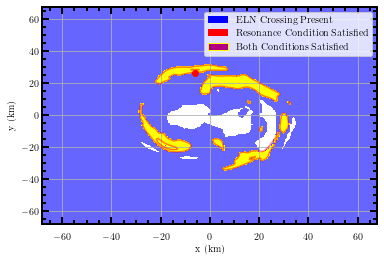

In [41]:
Merger_Grid(zval=99).contour_plot(x=91,y=139)

In [14]:
xkm[1,0]-xkm[0,0]

0.679616544138824

In [17]:
class AngularStuff:
    def __init__(self, data_loc = "/home/henryrpg/Desktop/N3AS/data/merger_grid.h5", 
                unrotated_data_loc = "/home/henryrpg/Desktop/N3AS/data/merger_grid_unrotated.h5",
                 p_abs=10**7, coordinate =[103,34,95], theta=0, phi=0,
                 rotate = True):
        
        
        #rotated data has ELN flux along z
        if rotate == True:
            self.merger_grid = h5py.File(data_loc, 'r')
        elif rotate == False:
            self.merger_grid = h5py.File(unrotated_data_loc, 'r')
        else:
            raise TypeError('rotate = True or False')
        
        #Electron fraction, baryon n density
        self.rho=np.array(self.merger_grid['rho(g|ccm)'])[coordinate[0],coordinate[1],coordinate[2]] #g/cm^3 (baryon mass density)
        self.Ye=np.array(self.merger_grid['Ye'])[coordinate[0],coordinate[1],coordinate[2]]
        self.n_b=self.rho/M_p*(hbar**3 * c**3)#eV^3 (baryon number density)

        #basis
        self.basis = sft.Basis(theta,phi)
        #momentum
        self.p_abs = p_abs
        
        #discriminant condition
        #self.discriminant = np.array(self.merger_grid['crossing_descriminant'])[coordinate[0],coordinate[1],coordinate[2]]
        
        self.J_e = (hbar**3 * c**3)*(np.array([self.merger_grid['n_e(1|ccm)'][coordinate[0],coordinate[1],coordinate[2]],
                                             self.merger_grid['fn_e(1|ccm)'][0,coordinate[0],coordinate[1],coordinate[2]],
                                             self.merger_grid['fn_e(1|ccm)'][1,coordinate[0],coordinate[1],coordinate[2]],
                                             self.merger_grid['fn_e(1|ccm)'][2,coordinate[0],coordinate[1],coordinate[2]]]))
                      
        self.J_a = (hbar**3 * c**3)*np.array([self.merger_grid['n_a(1|ccm)'][coordinate[0],coordinate[1],coordinate[2]],
                                              self.merger_grid['fn_a(1|ccm)'][0,coordinate[0],coordinate[1],coordinate[2]],
                                              self.merger_grid['fn_a(1|ccm)'][1,coordinate[0],coordinate[1],coordinate[2]],
                                              self.merger_grid['fn_a(1|ccm)'][2,coordinate[0],coordinate[1],coordinate[2]]])
        
        self.J_x = (hbar**3 * c**3)*np.array([self.merger_grid['n_x(1|ccm)'][coordinate[0],coordinate[1],coordinate[2]],
                                              self.merger_grid['fn_x(1|ccm)'][0,coordinate[0],coordinate[1],coordinate[2]],
                                              self.merger_grid['fn_x(1|ccm)'][1,coordinate[0],coordinate[1],coordinate[2]],
                                              self.merger_grid['fn_x(1|ccm)'][2,coordinate[0],coordinate[1],coordinate[2]]])
        
        #technically just the ee component of J
        self.J = self.J_e - self.J_a
        
        #Total (constant) flux, the trace of the particle flux. THE FACTOR BEHIND J_x MIGHT BE WRONG
        self.J_tot = self.J_e + self.J_x

        self.M = sft.M_2flavor
        
        self.S_R = 2**(1./2.)*G*np.transpose(np.array([[2*self.J,np.zeros_like(self.J)],[np.zeros_like(self.J),self.J]]),(2,0,1))
        self.S_L = -2**(1./2.)*G*np.transpose(np.array([[2*self.J,np.zeros_like(self.J)],[np.zeros_like(self.J),self.J]]),(2,1,0))
        
        #H_LR at a point
    def H_LR_at_basis(self,theta,phi):
        basis = sft.Basis(theta, phi)
        S_L_plus = sft.plus(self.S_L, basis)
        S_R_plus = sft.plus(self.S_R, basis)
        
        MSl = np.array(np.matmul(np.conj(self.M),S_L_plus))
        SrM = np.array(np.matmul(S_R_plus,np.conj(self.M)))
        return (-1/self.p_abs)*(SrM-MSl)
    
    def resonance_at_basis(self, theta, phi):
        
        basis = sft.Basis(theta,phi)
        S_R_kappa = sft.kappa(self.S_R,basis)

        return np.array(2**(-1/2)*G*self.n_b*(3.*self.Ye-np.ones_like(self.Ye))+S_R_kappa[0,0])

    #how do I make this work for different quantities
    def angular_plot(self, theta_precision = 200, phi_precision = 100, savefig = True):
        
        H_LR_angular = np.transpose((np.array([[((np.real(self.H_LR_at_basis(theta,phi)[0,0]))**2
                                               + (np.imag(self.H_LR_at_basis(theta,phi)[0,0]))**2)**(1/2)
                                            for theta in np.linspace(0,np.pi,theta_precision)] 
                                            for phi in np.linspace(0,2*np.pi,phi_precision)])))
        resonance_angular = np.transpose((np.array([[np.real(self.resonance_at_basis(theta,phi))  
                                            for theta in np.linspace(0,np.pi,theta_precision)] 
                                            for phi in np.linspace(0,2*np.pi,phi_precision)])))
        
        f = plt.figure()
        ax = f.add_subplot(projection = 'mollweide')
        ax.grid(False)
        H_LR_im = ax.pcolormesh(np.linspace(-np.pi,np.pi,phi_precision),
                                np.linspace(0.5*np.pi,-0.5*np.pi,theta_precision),
                                H_LR_angular, 
                                cmap=plt.cm.hot, shading='auto')
        plt.colorbar(H_LR_im)
        
        res_im = ax.contour(np.linspace(-np.pi,np.pi,phi_precision), 
                            np.linspace(0.5*np.pi,-0.5*np.pi,theta_precision),
                            resonance_angular, 
                            levels=[0.], colors='cyan')
        
        #add net flux point 
        ax.scatter([np.arctan2(self.J[2],self.J[1])],[np.arctan2(self.J[3],
                                                (self.J[1]**2+self.J[2]**2)**(1/2))],label = 'ELN Flux Direction')
        
        #ax.scatter([np.arctan2(self.J_tot[2],self.J_tot[1])],
         #          [np.arctan2(self.J_tot[3],(self.J_tot[1]**2+self.J_tot[2]**2)**(1/2))],
          #         label = 'Main Particle Flow')
        #ax.legend()
        #ax.set_title(r'$Angular \  Plot \ of \ H_{LR}$')
        #ax.facecolor='white'
        
        #if savefig == True:
        #    plt.tight_layout()
        #    plt.savefig('../angularplot.png', dpi=300 )
        #plt.show()

In [1]:
angles = np.transpose([[theta for theta in np.linspace(0,np.pi,200)] 
                                            for phi in np.linspace(0,2*np.pi,100)])
f = plt.figure()
ax = f.add_subplot(projection = 'mollweide')
ax.grid(False)
H_LR_im = ax.pcolormesh(np.linspace(-np.pi,np.pi,100),
                        np.linspace(0.5*np.pi,-0.5*np.pi,200),
                        angles, 
                        cmap=plt.cm.hot, shading='auto')
plt.colorbar(H_LR_im)
ax.scatter(0,0)

NameError: name 'np' is not defined

In [28]:
AngularStuff(rotate=True,coordinate=[106,136,99]).J

array([-5.08206343e+18, -3.20000000e+01,  0.00000000e+00,  5.12872608e+18])

In [69]:
#if skipping the above: set output_filename as the loc of the (already generated) h5 dataset you want to look at
data_base_directory = "/home/henryrpg/Desktop/N3AS/data/critpoint2.h5"
output_filename = data_base_directory[0:-3]+'_spin_flip_matrices_zdirr.h5'

#extract calculated data, show the datasets
# note - us|e h5ls in the terminal to peek inside a hdf5 file
data =  h5py.File(output_filename, "r") 
list(data.keys())

['GM(eV^3)I',
 'GM(eV^3)R',
 'H_LR(eV)I',
 'H_LR(eV)R',
 'H_L_free(eV)',
 'H_L_minusplus(eV)I',
 'H_L_minusplus(eV)R',
 'H_Lz(eV)I',
 'H_Lz(eV)R',
 'H_R_free(eV)',
 'H_R_plusminus(eV)I',
 'H_R_plusminus(eV)R',
 'H_Rz(eV)I',
 'H_Rz(eV)R',
 'J(eV^3)I',
 'J(eV^3)R',
 'J_a(eV^3)I',
 'J_a(eV^3)R',
 'J_p(eV^3)I',
 'J_p(eV^3)R',
 'S_L(eV)I',
 'S_L(eV)R',
 'S_L_kappa(eV)I',
 'S_L_kappa(eV)R',
 'S_L_minus(eV)I',
 'S_L_minus(eV)R',
 'S_L_plus(eV)I',
 'S_L_plus(eV)R',
 'S_R(eV)I',
 'S_R(eV)R',
 'S_R_kappa(eV)I',
 'S_R_kappa(eV)R',
 'S_R_minus(eV)I',
 'S_R_minus(eV)R',
 'S_R_plus(eV)I',
 'S_R_plus(eV)R',
 't(s)',
 'z(cm)']

In [17]:
49*0.679616544138824

33.301210662802376

In [29]:
#adds GM components of flux
GM_data = sft.GM_components(data) 
data.close()
data_append =  h5py.File(output_filename, "a")
sft.append_to_hdf5(data_append, "GM(eV^3)", GM_data)
data = h5py.File(output_filename, "r")

In [24]:
# for plots: choose 'basis' as your basis component (either 0,1,2, or 3) and 'data' as your read-permission h5 dataset

basis=3

data = h5py.File("/home/henryrpg/Desktop/N3AS/data/critpoint2_spin_flip_matrices_zdirr.h5", "r") 

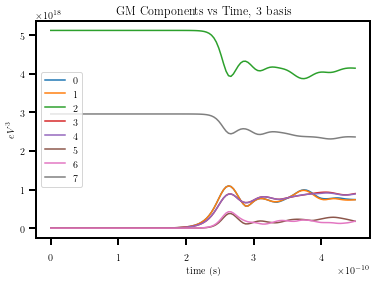

In [19]:
#plots flux GM components along chosen basis component
t = np.array(data["t(s)"])
plt.xlabel("time (s)")
plt.ylabel(r"$eV^3$")
plt.title('GM Components vs Time, '+str(basis)+ " basis")    
plt.plot(t,np.average(np.absolute(sft.total(data, 'GM(eV^3)')[0][:,basis,:,:]), axis=1),label=[str(k)for k in range(0,8)])
plt.legend()
plt.grid()

In [20]:
#plots [basis] component of Flux 


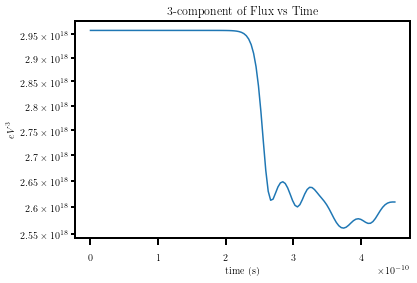

In [25]:
#plots [basis] component of Flux 
J=sft.total(data,"J(eV^3)")
t = np.array(data["t(s)"])
plt.xlabel("time (s)")
plt.ylabel(r"$eV^3$")
plt.title(str(basis)+'-component of Flux vs Time')    
plt.semilogy(t,np.average(sft.scalarfunc_time(J[:,3,:,:,:]), axis=1))
plt.grid()

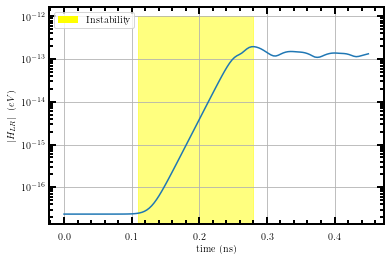

In [37]:
#plots H_LR
H_LR=sft.total(data,"H_LR(eV)")
t = np.array(data["t(s)"])
plt.xlabel("time (ns)")
plt.ylabel(r"$|H_{LR}| \ \ (eV)$")
#plt.ylim(1e-17,5e-13)
#plt.xlim(0,0.4)
#plt.title('Spin-Flip Hamiltionian Component during Fast Flavor Instability')    
plt.semilogy(10**9*t,np.average(sft.scalarfunc_time(H_LR[:,:,:,:]), axis=1))
plt.fill_between([0.11,0.28], 0, 1e-12, alpha=0.5, color='yellow')
proxy = [plt.Rectangle((1, 1), 2, 2, fc='yellow')]
plt.legend(proxy, ["Instability"], loc='upper left')
mpl.pyplot.tick_params(axis='both',which="both", direction="in",top=True,right=True)
mpl.pyplot.minorticks_on()


plt.grid()
plt.savefig('../H_LR.png', dpi=300)

In [ ]:
#plots the kappa component of the potential
kappa=sft.total(data,'S_R_kappa(eV)')
t = np.array(data["t(s)"])
plt.xlabel("time (s)")
plt.ylabel(r"$eV$")
plt.title('Kappa Component of Potential vs Time')    
plt.plot(t,np.average(kappa[:,0,0,:], axis=1))
plt.grid()
plt.savefig('../kappa.png', dpi=300)

In [ ]:
np.shape(kappa)

In [ ]:
#Plots neutrino-neutrino + vacuum part of diagonal component 
H_vv=sft.total(data,'H_Rz(eV)')
t = np.array(data["t(s)"])
plt.xlabel("time (s)")
plt.ylabel(r"$eV$")
plt.title(r'$H_{\nu\nu}+H_m$ vs Time')    
plt.plot(t,np.average(sft.scalarfunc_time(H_vv[:,:,:,:]), axis=1))
plt.grid()

In [ ]:
#Plots neutrino-neutrino + vacuum part of diagonal component against space (at time t)
t=0
H_vv=sft.total(data,'H_Rz(eV)')
z = np.array(data["z(cm)"])
plt.xlabel("position (cm)")
plt.ylabel(r"$eV$")
#plt.title('Spin-Flip Hamiltionian Component vs Space at t = '+str(t))    
plt.plot(z,H_vv[t,0,0,:])
plt.grid()

In [7]:


















#MERGER GRID FUNCTIONS: all plots involving 3d grid of data from the supernova merger (Rather than a single simulation)
merger_grid = h5py.File("/home/henryrpg/Desktop/N3AS/data/merger_grid.h5","r")
merger_grid_unrotated = h5py.File("/home/henryrpg/Desktop/N3AS/data/merger_grid_unrotated.h5","r")
merger_grid_unrotated.keys()
#use the km units, not the cm


<KeysViewHDF5 ['J_a(erg|ccm)', 'J_e(erg|ccm)', 'J_x(erg|ccm)', 'Ye', 'crossing_discriminant', 'deltaCrossingAngle', 'eddfac_a(1|ccm)', 'eddfac_e(1|ccm)', 'eddfac_x(1|ccm)', 'fluxfac_a(1|ccm)', 'fluxfac_e(1|ccm)', 'fluxfac_x(1|ccm)', 'fn_a(1|ccm)', 'fn_e(1|ccm)', 'fn_x(1|ccm)', 'minerbo_Za', 'minerbo_Ze', 'minerbo_Zx', 'n_a(1|ccm)', 'n_e(1|ccm)', 'n_x(1|ccm)', 'rho(g|ccm)', 'x(cm)', 'x(km)', 'y(cm)', 'y(km)', 'z(cm)']>

In [14]:
location = [106,136,99]
merger_grid['J_e(erg|ccm)'][106,136,99]


1.5490443933176497e+28

In [18]:
xkm[106,0]

4.077699264833035

In [21]:
fluxfac_e = np.array(merger_grid['eddfac_e(1|ccm)'])

In [22]:
np.shape(fluxfac_e)

(201, 201, 101)

/tmp/ipykernel_190/2108109855.py:204: MatplotlibDeprecationWarning: Auto-removal of grids by pcolor() and pcolormesh() is deprecated since 3.5 and will be removed two minor releases later; please call grid(False) first.
  plt.colorbar(label=r'$log(\gamma)$')


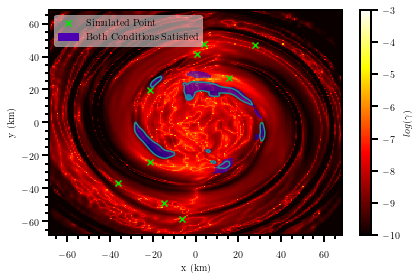

In [58]:
Merger_Grid(theta=pi/2).adiab_plot(theta_res = pi,crit_region=True)

In [59]:
#hdf5 append? 
#new projection only showing half the angular space?


In [60]:
Merger_Grid(theta=pi/2).adiab_plot(zval = 5,minval = 1E-5, crit_region =True, savefig=True)

TypeError: adiab_plot() got an unexpected keyword argument 'zval'

In [ ]:
merger_grid = h5py.File("/home/henryrpg/Desktop/N3AS/data/merger_grid.h5","r")
merger_grid_unrotated = h5py.File("/home/henryrpg/Desktop/N3AS/data/merger_grid_unrotated.h5","r")
merger_grid_unrotated.keys()
#use the km units, not the cm units

In [61]:
#constants and values
G=1.1663787*10**(-23) # eV^-2
c=2.998e+10 #cm/s
M_p=1.6726219*10**(-24)#grams (Proton mass)
rho=np.array(merger_grid['rho(g|ccm)']) #g/cm^3 (baryon mass density)
Ye=np.array(merger_grid['Ye'])
hbar=6.58211951*10**(-16) #eV s
n_b=rho/M_p*(hbar**3 * c**3)#eV^3 (baryon number density)

#x,y axes
x_km=np.array(merger_grid['x(km)'])[0]
y_km=np.array(merger_grid['y(km)'])[0]

#discriminant condition
discriminant=np.array(merger_grid['crossing_descriminant'])
discriminant_unrotated=np.array(merger_grid_unrotated['crossing_discriminant'])

positive=np.where(discriminant>=0)
negative=np.where(discriminant<0)

discriminant_sign=np.zeros_like(discriminant)

discriminant_sign[positive]=1
discriminant_sign[negative]=0

In [16]:
J_e=(hbar**3 * c**3)*(np.array([merger_grid['n_e(1|ccm)'],
              merger_grid['fn_e(1|ccm)'][0],merger_grid['fn_e(1|ccm)'][1],merger_grid['fn_e(1|ccm)'][2]]))
                      

In [17]:
np.array(J_e).shape

(4, 201, 201, 101)

In [15]:
#4-component flux vectors for electron neutrinos (e), electron antineutrinos (a), and other neutrinos (x)
#all in eV^3
J_e=(hbar**3 * c**3)*(np.array([merger_grid['n_e(1|ccm)'],
              merger_grid['fn_e(1|ccm)'][0],merger_grid['fn_e(1|ccm)'][1],merger_grid['fn_e(1|ccm)'][2]]))
                      
J_a=(hbar**3 * c**3)*np.array([merger_grid['n_a(1|ccm)'],
              merger_grid['fn_a(1|ccm)'][0],merger_grid['fn_a(1|ccm)'][1],merger_grid['fn_a(1|ccm)'][2]])
                      
J = J_e - J_a 

#computing max, min values of the resonance condition
mag_F=np.sqrt(np.sum(J[1:4,:,:,:]**2, axis=0))
H_vv_min=2**(1./2.)*G*(J[0]+mag_F)
H_vv_max=2**(1./2.)*G*(J[0]-mag_F)
resonance_val_max = 2**(-1/2)*G*n_b*(3.*Ye-np.ones_like(Ye))+H_vv_max
resonance_val_min = 2**(-1/2)*G*n_b*(3.*Ye-np.ones_like(Ye))+H_vv_min



#conditions
positive_resonance=np.where(resonance_val_min>=0)

resonance_sign=np.zeros_like(discriminant)
resonance_sign[positive_resonance]=1

both_conditions=resonance_sign*discriminant_sign

NameError: name 'n_b' is not defined

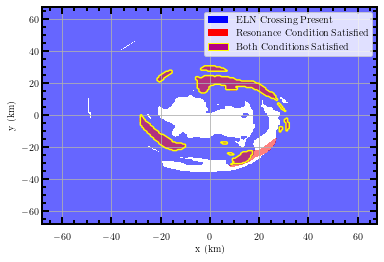

In [63]:
#see cntours at z=zval
zval=95
#colorplot=plt.pcolormesh(x[:,:,zval],y[:,:,zval],discriminant[:,:,zval],cmap=plt.cm.RdYlBu,shading='auto',vmax=0.3,vmin=-0.3)
#plt.colorbar()
cs=plt.contourf(x_km[:,:,zval],y_km[:,:,zval], discriminant_sign[:,:,zval], levels=[0.1,1,2,3], alpha=0.6, colors=['blue','red',[0.65,0,0.25]])
proxy = [plt.Rectangle((1, 1), 2, 2, fc='blue'),plt.Rectangle((1, 1), 2, 2, fc='red'),plt.Rectangle((1, 1), 2, 2, fc=[0.7,0,0.5],ec='yellow')]

plt.legend(proxy, ["ELN Crossing Present", "Resonance Condition Satisfied","Both Conditions Satisfied"])
plt.contourf(x_km[:,:,zval],y_km[:,:,zval],resonance_val_min[:,:,zval], levels=[0,1], alpha=0.5, colors=['red'])
plt.contour(x_km[:,:,zval],y_km[:,:,zval],both_conditions[:,:,zval], levels=[0.5,1], colors=['yellow'] )
mpl.pyplot.tick_params(axis='both',which="both", direction="in",top=True,right=True)
mpl.pyplot.minorticks_on()
plt.xlabel('x (km)')
plt.ylabel('y (km)')
#plt.contour(x[:,:,zval],y[:,:,zval],resonance_val_max[:,:,zval], levels=[0], colors=['blue'] )
#plt.title('Resonance Conditions and ELN Crossing Regions')
plt.savefig('../'+str(zval)+'.png', dpi=300)

In [51]:
############################
#angle-dependent resonance##
###########################

J_e=(hbar**3 * c**3)*(np.array([merger_grid['n_e(1|ccm)'],
              merger_grid['fn_e(1|ccm)'][0],merger_grid['fn_e(1|ccm)'][1],merger_grid['fn_e(1|ccm)'][2]]))
                      
J_a=(hbar**3 * c**3)*np.array([merger_grid['n_a(1|ccm)'],
              merger_grid['fn_a(1|ccm)'][0],merger_grid['fn_a(1|ccm)'][1],merger_grid['fn_a(1|ccm)'][2]])
#rotated data: max ELN flux along z
J_merger=J_e-J_a




J_eu=(hbar**3 * c**3)*(np.array([merger_grid_unrotated['n_e(1|ccm)'],
              merger_grid_unrotated['fn_e(1|ccm)'][0],merger_grid_unrotated['fn_e(1|ccm)'][1],merger_grid_unrotated['fn_e(1|ccm)'][2]]))
                      
J_au=(hbar**3 * c**3)*np.array([merger_grid_unrotated['n_a(1|ccm)'],
              merger_grid_unrotated['fn_a(1|ccm)'][0],merger_grid_unrotated['fn_a(1|ccm)'][1],merger_grid_unrotated['fn_a(1|ccm)'][2]])
#unrotated
J_u=J_eu-J_au

In [52]:
#returns the value of the resonance condition with the given basis
def resonance_val(J, basis):
   
    S_R = 2**(1./2.)*G*np.transpose(np.array([[2*J,np.zeros_like(J)],[np.zeros_like(J),J]]),(2,0,1,3,4,5))
    
    S_R_kappa = sft.kappa(S_R,basis)
    
    return np.array(2**(-1/2)*G*n_b*(3.*Ye-np.ones_like(Ye))+S_R_kappa[0,0])

#gets the gradient
def grad_magnitude(J, basis):

    grad=np.gradient(resonance_val(J,basis), 0.67928832684*1e5/(c*hbar))
    projection=np.sum(basis.n_vector[1:4,np.newaxis,np.newaxis,np.newaxis]*grad, axis=0)
    
    return np.array(np.abs(projection))

#gets H_LR
def H_LRf(J, basis):
    M=sft.M_2flavor
    p_abs=10**7
    S_R = 2**(1./2.)*G*np.transpose(np.array([[2*J,np.zeros_like(J)],[np.zeros_like(J),J]]),(2,0,1,3,4,5))
    S_L = -2**(1./2.)*G*np.transpose(np.array([[2*J,np.zeros_like(J)],[np.zeros_like(J),J]]),(2,1,0,3,4,5))
    S_L_minus = sft.minus(S_L, basis)
    S_R_plus = sft.plus(S_R, basis)
    
    MSl = np.transpose(np.array([[[ np.matmul(np.conj(M),S_L_minus[:,:,x,y,z]) for z in range(101) ] for y in range(201)] for x in range(201)]),(3,4,0,1,2))
    SrM = np.transpose(np.array([[[ np.matmul(S_R_plus[:,:,x,y,z],np.conj(M))  for z in range(101) ] for y in range(201)] for x in range(201)]) ,(3,4,0,1,2))
    return (-1/p_abs)*(SrM-MSl)

#gets gamma
def adiabaticity(J,basis):
    return np.real((H_LRf(J,basis)[0,0]**2)/grad_magnitude(J,basis))

#gets indices of points where adiab is greater than value at z
def max_adiab(adiab,z,value):
    maxvals=np.where(adiab>value)
    coordlist=[]
    for n in range(0,len(maxvals[2])):
        if maxvals[2][n]==z:
            coordlist.append([int(maxvals[0][n]),int(maxvals[1][n])])
    return np.array(coordlist)

#gets the coordinates of the points of adiab higher than value (for plotting)
def coords(adiab,z,value):
    maxpoints=max_adiab(adiab,z,value)
    xlist=[x_km[val[0],val[1],z] for val in maxpoints]
    ylist=[y_km[val[0],val[1],z] for val in maxpoints]
    return xlist,ylist

In [53]:
basis=sft.Basis(np.pi/2,0)
adiab= adiabaticity(J_merger,basis)

In [20]:
np.where(np.array([[1,2,3],[4,5,6]])>5)

(array([1]), array([2]))

In [20]:
basis=sft.Basis(np.pi/2,0)
H_LR_x=H_LRf(J_merger,basis)
adiabaticity_x_unrotated=adiabaticity(J_u,basis)

In [23]:
basis=sft.Basis(0,0)
gradz=grad_magnitude(J_u, basis)
gradx=grad_magnitude(J_u,sft.Basis(np.pi/2,0))

In [24]:
optimal_adiabaticity = np.real((H_LR_x[0,0]**2)/gradz)

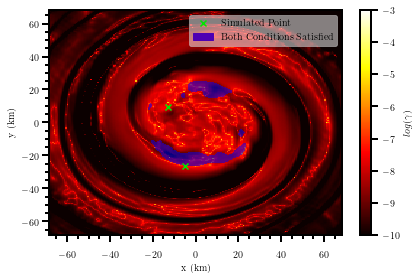

In [59]:
#see contours at z=zval
zval=13
colorplot=plt.pcolormesh(x_km[:,:,zval],y_km[:,:,zval],np.log10(optimal_adiabaticity[:,:,zval]),cmap=plt.cm.hot,shading='auto', vmax=-3, vmin=-10)
plt.xlabel('x (km)')
plt.ylabel('y (km)')
plt.colorbar(label=r'$log(\gamma)$')
contourf=plt.contourf(x_km[:,:,zval],y_km[:,:,zval],both_conditions[:,:,zval], alpha=0.5, levels=[0.5,1], colors=['blue'] )
proxy = [plt.Rectangle((1, 1), 2, 2, fc=pc.get_facecolor()[0]) for pc in
contourf.collections]

#mpl.pyplot.tick_params(axis='both',which="both", direction="in",top=True,right=True)
mpl.pyplot.minorticks_on()
scatter=plt.scatter(coords(optimal_adiabaticity,zval,1e-4)[0],coords(optimal_adiabaticity,zval,1e-4)[1],color=[0,0.9,0], marker='x', label='Simulated Point')
red_patch = mpatches.Patch(color=[0.3,0,0.7], label='The red data')
plt.legend(handles=[scatter,red_patch], labels=["Simulated Point","Both Conditions Satisfied"], frameon = 1, framealpha=0.5)
plt.tight_layout()
plt.savefig('../'+str(zval)+'.png', dpi=300)

In [70]:
#Generate Gif
file_list=[]
for zval in range(0,99):   

    
    colorplot=plt.pcolormesh(x_km[:,:,zval],y_km[:,:,zval],np.log10(optimal_adiabaticity[:,:,zval]),cmap=plt.cm.hot,shading='auto', vmax=-3, vmin=-10)
    plt.xlabel('x (km)')
    plt.ylabel('y (km)')
    plt.title('z = '+str(zval))
    plt.colorbar(label=r'$log(\gamma)$')
    contourf=plt.contourf(x_km[:,:,zval],y_km[:,:,zval],both_conditions[:,:,zval], alpha=0.5, levels=[0.5,1], colors=['blue'] )
    proxy = [plt.Rectangle((1, 1), 2, 2, fc=pc.get_facecolor()[0]) for pc in
    contourf.collections]

    #mpl.pyplot.tick_params(axis='both',which="both", direction="in",top=True,right=True)
    mpl.pyplot.minorticks_on()
    scatter=plt.scatter(coords(optimal_adiabaticity,zval,1e-4)[0],coords(optimal_adiabaticity,zval,1e-4)[1],color=[0,0.9,0], marker='x', label='Simulated Point')

    red_patch = mpatches.Patch(color=[0.3,0,0.7], label='The red data')
    plt.legend(handles=[scatter,red_patch], labels=["Simulated Point","Both Conditions Satisfied"], frameon = 1, framealpha=0.5)
    plt.tight_layout()
    plt.savefig('../'+str(zval)+'.png', dpi=300)
    
    file_list.append(str(zval)+'.png')
    plt.clf()

<Figure size 432x288 with 0 Axes>

In [71]:
import imageio
# Build GIF
with imageio.get_writer('../data.gif', mode='I', fps=5) as writer:
    for filename in file_list:
        image = imageio.imread('../'+filename)
        writer.append_data(image)
for filename in set(file_list):
    os.remove('../'+filename)

In [48]:
#angular plots
def H_LR_coord(J, basis, coordinate):
    M=sft.M_2flavor
    J_coord=J[:,coordinate[0],coordinate[1],coordinate[2]]
    p_abs=10**7
    S_R = 2**(1./2.)*G*np.transpose(np.array([[2*J_coord,np.zeros_like(J_coord)],[np.zeros_like(J_coord),J_coord]]),(2,0,1))
    S_L = -2**(1./2.)*G*np.transpose(np.array([[2*J_coord,np.zeros_like(J_coord)],[np.zeros_like(J_coord),J_coord]]),(2,1,0))
    S_L_plus = sft.plus(S_L, basis)
    S_R_plus = sft.plus(S_R, basis)
    
    MSl = np.array(np.matmul(np.conj(M),S_L_plus))
    SrM = np.array(np.matmul(S_R_plus,np.conj(M)))
    return (-1/p_abs)*(SrM-MSl)

In [23]:
theta=np.pi/5
mixing = np.array([[np.cos(theta),np.sin(theta)],
                   [-np.sin(theta),np.cos(theta)]])
mass = np.array([[1,0],[0,2]])


In [46]:
num_flux_rotated = np.array(merger_grid['fn_e(1|ccm)'])
num_flux_unrotated = merger_grid_unrotated['fn_e(1|ccm)']
num_flux_rotated = np.array(merger_grid['fn_e(1|ccm)'])
num_flux_unrotated = merger_grid_unrotated['fn_e(1|ccm)']

In [52]:
np.shape(J_plot)

(4, 201, 201, 101)

In [54]:
num_flux_rotated = np.array(merger_grid['fn_e(1|ccm)'])
num_flux_unrotated = merger_grid_unrotated['fn_e(1|ccm)']
num_flux_rotated = np.array(merger_grid['fn_e(1|ccm)'])
num_flux_unrotated = merger_grid_unrotated['fn_e(1|ccm)']
coordinates=[1,134,10]
J_plot=J_merger
num_flux = num_flux_rotated

H_LR_crit=np.transpose((np.array([[((np.real(H_LR_coord(J_plot,sft.Basis(theta,phi),coordinates)[0,0]))**2+
                                   (np.imag(H_LR_coord(J_plot,sft.Basis(theta,phi),coordinates)[0,0]))**2)**(1/2)
             for theta in np.linspace(0,np.pi,200)] for phi in np.linspace(0,2*np.pi,100)])))
fig=plt.figure()
ax = fig.add_subplot(projection="mollweide")


im=ax.pcolormesh(np.linspace(-np.pi,np.pi,100), np.linspace(-0.5*np.pi,0.5*np.pi,200), H_LR_crit,cmap=plt.cm.hot,shading='auto')
plt.colorbar(im)

#add net flux point
J_point=J_plot[:,coordinates[0],coordinates[1],coordinates[2]]
ax.scatter([np.arctan2(J_point[2],J_point[1])],[np.arctan2(J_point[3],(J_point[1]**2+J_point[2]**2)**(1/2))])
#add number flux point
num_flux_point = num_flux[:,coordinates[0],coordinates[1],coordinates[2]]
ax.scatter([np.arctan2(num_flux_point[1],num_flux_point[0])],[np.arctan2(num_flux_point[2],(num_flux_point[1]**2+num_flux_point[0]**2)**(1/2))])
#ax.scatter([np.pi/3],[0])


ax.facecolor='white'
plt.show()

NameError: name 'H_LR_coord' is not defined

In [ ]:
#compute total flux direction as f_e+f_x(*2?)

In [53]:
#Evolved data
t=0
#num_flux = num_flux_rotated

H_LR_crit=np.transpose((np.array([[((np.real(H_LR_coord(J_evolved[t,:,0,0,0],sft.Basis(theta,phi),coordinates)[0,0]))**2+
                                   (np.imag(H_LR_coord(J_evolved[t,:,0,0,0],sft.Basis(theta,phi),coordinates)[0,0]))**2)**(1/2)
             for theta in np.linspace(0,np.pi,200)] for phi in np.linspace(0,2*np.pi,100)])))
fig=plt.figure()
ax = fig.add_subplot(projection="mollweide")


im=ax.pcolormesh(np.linspace(-np.pi,np.pi,100), np.linspace(-0.5*np.pi,0.5*np.pi,200), H_LR_crit,cmap=plt.cm.hot,shading='auto')
plt.colorbar(im)

#add net flux point
J_point=J_plot[:,coordinates[0],coordinates[1],coordinates[2]]
ax.scatter([np.arctan2(J_point[2],J_point[1])],[np.arctan2(J_point[3],(J_point[1]**2+J_point[2]**2)**(1/2))])
#add number flux point
num_flux_point = num_flux[:,coordinates[0],coordinates[1],coordinates[2]]
ax.scatter([np.arctan2(num_flux_point[1],num_flux_point[0])],[np.arctan2(num_flux_point[2],(num_flux_point[1]**2+num_flux_point[0]**2)**(1/2))])
#ax.scatter([np.pi/3],[0])



plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 4 were indexed

In [63]:
#if skipping the above: set output_filename as the loc of the (already generated) h5 dataset you want to look at
data_base_directory = "/home/henryrpg/Desktop/N3AS/data/critpoint2.h5"
output_filename = data_base_directory[0:-3]+'_spin_flip_matrices_zdirr.h5'

#extract calculated data, show the datasets
# note - us|e h5ls in the terminal to peek inside a hdf5 file
data =  h5py.File(output_filename, "r") 
list(data.keys())

['GM(eV^3)I',
 'GM(eV^3)R',
 'H_LR(eV)I',
 'H_LR(eV)R',
 'H_L_free(eV)',
 'H_L_minusplus(eV)I',
 'H_L_minusplus(eV)R',
 'H_Lz(eV)I',
 'H_Lz(eV)R',
 'H_R_free(eV)',
 'H_R_plusminus(eV)I',
 'H_R_plusminus(eV)R',
 'H_Rz(eV)I',
 'H_Rz(eV)R',
 'J(eV^3)I',
 'J(eV^3)R',
 'J_a(eV^3)I',
 'J_a(eV^3)R',
 'J_p(eV^3)I',
 'J_p(eV^3)R',
 'S_L(eV)I',
 'S_L(eV)R',
 'S_L_kappa(eV)I',
 'S_L_kappa(eV)R',
 'S_L_minus(eV)I',
 'S_L_minus(eV)R',
 'S_L_plus(eV)I',
 'S_L_plus(eV)R',
 'S_R(eV)I',
 'S_R(eV)R',
 'S_R_kappa(eV)I',
 'S_R_kappa(eV)R',
 'S_R_minus(eV)I',
 'S_R_minus(eV)R',
 'S_R_plus(eV)I',
 'S_R_plus(eV)R',
 't(s)',
 'z(cm)']

In [44]:
data = h5py.File("/home/henryrpg/Desktop/N3AS/data/critpoint2_spin_flip_matrices_zdirr.h5", "r") 
data.keys()
J_evolved=sft.total(data,"J(eV^3)")

In [116]:
J_point

array([ 1.51662244e+17,  4.48465155e+17, -5.75299743e+16,  1.52063840e+17])

In [ ]:
coordinates=[103,134,95]
J_plot=J_merger
H_LR_crit=np.transpose(np.real(np.array([[H_LR_coord(J_plot,sft.Basis(theta,phi),coordinates)[0,0]
            for theta in np.linspace(0,np.pi,200)] for phi in np.linspace(0,2*np.pi,100)])))
fig=plt.figure()
ax = fig.add_subplot(projection="aitoff")
J_point=J_plot[:,coordinates[0],coordinates[1],coordinates[2]]
im=ax.pcolormesh(np.linspace(-np.pi,np.pi,100), np.linspace(-0.5*np.pi,0.5*np.pi,200), H_LR_crit,cmap=plt.cm.hot,shading='auto')
plt.colorbar(im)
ax.scatter([np.arctan2(J_point[2],J_point[1])],[np.arctan2(J_point[3],(J_point[1]**2+J_point[2]**2)**(1/2))])
ax.scatter([np.pi+np.arctan2(J_point[2],J_point[1])],[-np.arctan2(J_point[3],(J_point[1]**2+J_point[2]**2)**(1/2))])


#ax.set_title("A line plot on a polar axis", va='bottom')
plt.show()

In [309]:
J_point=J_u[:,103,134,95]
np.arctan2(J_point[2],J_point[1])

-1.7521168107114542

In [ ]:
Jprojection=np.array([[J*cos(phi)]])

In [ ]:
plt.figure()
ax = plt.subplot(projection="aitoff")
ax.pcolormesh(np.linspace(-np.pi,np.pi,10), np.linspace(-0.5*np.pi,0.5*np.pi,20), H_LR_crit,cmap=plt.cm.hot,shading='auto')
plt.colorbar
#ax.scatter([0],[0])


#ax.set_title("A line plot on a polar axis", va='bottom')
plt.show()

In [111]:
def shouldITakeMyMidterm(MT1_score, MT2_score):
    Final_score = np.linspace(50,100,50)
    worse_MT = min([MT1_score, MT2_score])
    better_MT = max([MT1_score, MT2_score])
    
    grade_if_yes = []
    for n in range(0,50):
        if worse_MT<Final_score[n]:
            grade_if_yes.append( (Final_score[n]*0.45 + better_MT*0.15 + 40) )
        else:
            grade_if_yes.append( (Final_score[n]*0.30 + worse_MT*0.15 + better_MT*0.15 + 40) )
    
    grade_if_yes = np.array(grade_if_yes)
    grade_if_no = np.array([Final_score[n]*0.45 + MT2_score*0.15 + 40 for n in range(0,50)])
    
    f, ax = plt.subplots()
   
    x_axis = range(50,100)
    ax.set_ylabel('Total Grade')
    ax.set_xlabel('Grade on the Final')
    ax.plot(x_axis, grade_if_yes, color='blue', label="grade if I midterm")
    ax.plot(x_axis, grade_if_no, color='red', label="grade if I ski")
    
    min_important_score = min(np.where(np.trunc(grade_if_yes) ==90)[0])
    max_important_score = min(np.where(np.trunc(grade_if_no) ==90)[0])
    ax.axhline(90, color='magenta',linestyle='--', label = 'Cutoff for an A')

    plt.fill_between([min_important_score+49, max_important_score+49], 75, 100, alpha=0.5, color='yellow')
    proxy = [plt.Rectangle((1, 1), 2, 2, fc='yellow')]
    plt.legend(proxy, ["Instability"], loc='upper left')
    ax.legend()
    


   

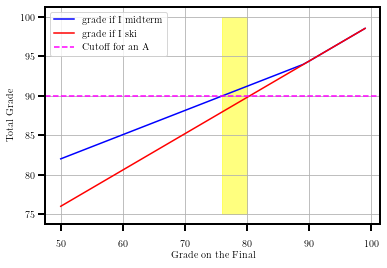

In [112]:
shouldITakeMyMidterm(90,90)